In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
from scipy import stats
from scipy import optimize
from scipy.optimize import minimize

# typehints
from typing import Union, List, Tuple

"""
Own packages
"""

from codelib.statistics.covariance import corr_to_cov_matrix, form_block_corr_matrix, corr_to_cov_matrix, cov_to_corr_matrix

from codelib.portfolio_optimization.mean_variance import portfolio_mean, portfolio_std, portfolio_variance
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks, calculate_risk_contributions, calculate_marginal_sharpe

from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.visualization.base import risk_waterfall_chart, correlation_plot, fan_chart

# Views
from codelib.portfolio_optimization.views import ProbabilitySolver, CorrelationView,MeanView, VolatilityView, weighted_percentile
from codelib.portfolio_optimization.views import effective_sample_size_entropy, calculate_correlation, View
from codelib.portfolio_optimization.views import calculate_correlation, calculate_variance, calculate_std, calculate_covariance


# fixed income 
from codelib.fixed_income.curves.cir_curve import CIRCurve
from codelib.fixed_income.cash_flows import CashFlow

# Ordinary Exam 2021 - Not So Normal Markets

# Data generating process (simulating gaussian mixture)

In [2]:
"""
Define inputs
"""
num_assets = 10

vols_1 = np.array([0.15, 0.15, 0.15, 0.14, 0.12, 0.11, 0.11, 0.10, 0.10, 0.09])
vols_2 = vols_1 + np.ones(num_assets) * 0.05

mu_1  = vols_1 * 0.75
mu_2 = vols_2 * (-0.5)

prob_crisis = 0.2
num_sim = 10000
horizon = 5

In [3]:
block_corr_mat_1 = form_block_corr_matrix(1, num_assets, 0.5)
block_corr_mat_2 = form_block_corr_matrix(1, num_assets, 0.95)

In [4]:
noise_corr_mat = np.cov(np.random.normal(size=(num_assets, num_assets)), rowvar=False)

In [5]:
alpha = 0.75
corr_mat_1 = block_corr_mat_1 * alpha + (1-alpha) * noise_corr_mat
corr_mat_1 = cov_to_corr_matrix(corr_mat_1)

corr_mat_2 = block_corr_mat_2 * alpha + (1-alpha) * noise_corr_mat
corr_mat_2 = cov_to_corr_matrix(corr_mat_2)

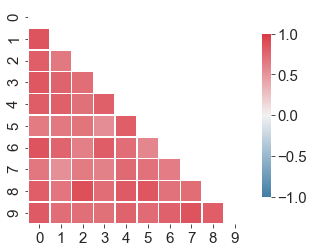

In [6]:
correlation_plot(corr_mat_2)

In [7]:
corr_mat_2

array([[1.        , 0.85812598, 0.80420328, 0.83844671, 0.80898574,
        0.64641737, 0.85876859, 0.66897748, 0.80455982, 0.82261022],
       [0.85812598, 1.        , 0.65293978, 0.77654109, 0.79429338,
        0.65438026, 0.77180763, 0.52806737, 0.6742051 , 0.71649133],
       [0.80420328, 0.65293978, 1.        , 0.71751896, 0.70161418,
        0.67980508, 0.62146584, 0.64189549, 0.88234843, 0.71000788],
       [0.83844671, 0.77654109, 0.71751896, 1.        , 0.79455402,
        0.54192953, 0.80562857, 0.61473546, 0.71431148, 0.70186124],
       [0.80898574, 0.79429338, 0.70161418, 0.79455402, 1.        ,
        0.79842258, 0.71563999, 0.73567644, 0.81961607, 0.77759785],
       [0.64641737, 0.65438026, 0.67980508, 0.54192953, 0.79842258,
        1.        , 0.5830287 , 0.69314179, 0.84505213, 0.72703498],
       [0.85876859, 0.77180763, 0.62146584, 0.80562857, 0.71563999,
        0.5830287 , 1.        , 0.63871384, 0.69184066, 0.78324069],
       [0.66897748, 0.52806737, 0.6418954

In [8]:
cov_mat_1 = corr_to_cov_matrix(corr_mat=corr_mat_1, vols=vols_1)
cov_mat_2 = corr_to_cov_matrix(corr_mat=corr_mat_2, vols=vols_2)

In [9]:
def simulate_asset_prices(mu1, mu2, cov_mat1, cov_mat2, prob1, horizon, num_sim):
        
    num_assets = len(mu1)
    num_periods = int(horizon)
    
    # allocate memory
    asset_prices = np.ones((num_sim, 1 + num_periods, num_assets))
    
    # bernoulli random variables to indicate which distribution to draw from 
    indicator = stats.bernoulli.rvs(prob1, size=(num_sim, num_periods))
    
    # simulate returns
    log_ret = (indicator[:, :, None] * np.random.multivariate_normal(mu1, cov_mat1, size=(num_sim, num_periods))
               + (1 - indicator[:, :, None]) * np.random.multivariate_normal(mu2, cov_mat2, size=(num_sim, num_periods)))
    
    # transform returns to asset prices
    asset_prices[:, 1:, :] = np.exp(np.cumsum(log_ret, axis=1))
    
    return asset_prices, log_ret

In [10]:
sim_prices, sim_log_ret = simulate_asset_prices(mu1=mu_1, mu2=mu_2, cov_mat1=cov_mat_1, cov_mat2=cov_mat_2,
                                        prob1=1-prob_crisis, horizon=horizon, num_sim=num_sim)

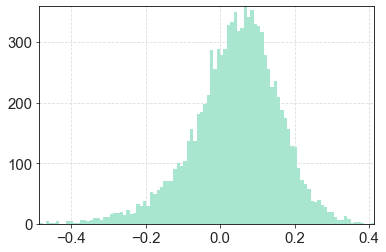

In [11]:
plt.hist(sim_log_ret[:,1, 9], bins=100);

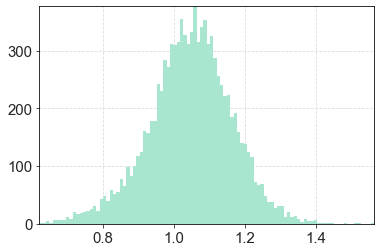

In [12]:
plt.hist(sim_prices[:,1, 9], bins=100);

In [13]:
"""
Save data
"""

if False: 
    for i in range(num_assets):
        data = pd.DataFrame(data=sim_prices[:, :, i], columns=np.arange(0, 6))
        data.to_csv("asset_{}.csv".format(1 + i))

# Guided Solution

Below, I will examplify how to solve the problems. I will not, necessarily, provide the full solution. 

There may be many ways to solve some of the problems, so the calculations presented below is not the only way. 

# Problem 1

## Load data

The first step in the analysis is to load the data into a Jupyter notebook. This can be done in different ways. I will consider two different ways: 

* Load into a pandas data frame for calculating risk measures
* Load into a numpy array for later work in the portfolio optimization exercises. 

In [14]:
num_assets = 10

"""
Create a data frame with all relevant data 
"""

df_list = list()

for i in range(num_assets):   
    asset_name = 'asset_{}'.format(i + 1)
    df  =  pd.read_csv(asset_name + ".csv", index_col=0)
    df.columns = ['Year 0', 'Year 1', 'Year 2', 'Year 3', 'Year 4', 'Year 5']
    df['Asset'] = i + 1
    
    df_list.append(df)
    
df_asset_data = pd.concat(df_list)

In [15]:
df_asset_data

,Year 0,Year 1,Year 2,Year 3,Year 4,Year 5,Asset
0,1.0,0.975656,1.074325,1.225908,1.276205,2.036425,1
1,1.0,0.931449,1.016307,1.100991,1.249622,1.356230,1
2,1.0,0.877482,0.803039,1.373275,1.560799,2.019056,1
3,1.0,0.926806,1.020267,1.229645,1.716342,1.926052,1
4,1.0,1.213905,1.106611,1.244074,1.945590,2.057221,1
...,...,...,...,...,...,...,...
9995,1.0,1.089486,1.044645,1.104086,1.023706,1.151675,10
9996,1.0,1.211665,1.242649,1.276444,1.134933,1.232638,10
9997,1.0,0.932106,0.856758,0.898386,1.051691,1.151866,10
9998,1.0,1.105483,0.971808,1.070347,1.133866,1.125541,10


In [16]:
"""
Create a numpy array with all price data
"""

asset_dict = dict()

for i in range(num_assets):   
    asset_name = 'asset_{}'.format(i + 1)
    asset_dict[asset_name] = pd.read_csv(asset_name + ".csv", index_col=0).values

prices = np.empty((10000, 6, 10)) # num_sim x num_per x num_assets
for i, vals in enumerate(list(asset_dict.values())):
    prices[:, :, i] = vals

## Descriptive statistics for individual assets

We can take different approaches. One possibility will be to use `numpy` function directly on the numpy array. The resulting data can then be used to construct a table for the report. 

In [17]:
"""
Example with expected value of return distribution  (each year, all assets)
"""

expected_return = np.mean(prices, axis=0) - 1

print(expected_return.shape)

(6, 10)


An alternative approach will be to use `pandas` functionality (other descriptive statistics such a max, min, etc. could also be relevant)

In [18]:
"""
Price data
"""

df_asset_data.groupby('Asset').agg(['mean', 'std', 'skew', stats.kurtosis]).loc[:, ['Year 1', 'Year 5']]

Year 1                                  Year 5                      \
           mean       std      skew  kurtosis      mean       std      skew   
Asset                                                                         
1      1.092798  0.189981  0.160498  0.284392  1.544342  0.630468  1.052919   
2      1.095515  0.192603  0.185659  0.264738  1.544306  0.629056  1.106931   
3      1.091915  0.191742  0.197202  0.238371  1.535913  0.618368  1.094611   
4      1.085131  0.181280  0.158357  0.393319  1.489003  0.569249  0.991692   
5      1.070206  0.153326  0.040871  0.344166  1.390207  0.455167  0.809633   
6      1.063204  0.140139 -0.075311  0.337418  1.348795  0.410607  0.742998   
7      1.061836  0.140387 -0.066703  0.308008  1.342453  0.406595  0.743284   
8      1.056576  0.127525 -0.133624  0.364682  1.307352  0.364608  0.556450   
9      1.056067  0.128044 -0.129932  0.382854  1.303866  0.360752  0.589246   
10     1.049896  0.116365 -0.186837  0.433444  1.268294  0.321858  0.505880   

                 
       kurtosis  
Asset            
1      1.879193  
2      2.426016  
3      2.250285  
4      1.809111  
5      1.419400  
6      1.120181  
7      1.244318  
8      0.514405  
9      0.718625  
10     0.459132

In [19]:
"""
Return data
"""
df_return_data = df_asset_data.copy()
df_return_data.iloc[:, :-1] = df_return_data.iloc[:, :-1] - 1.0
df_return_data.groupby('Asset').agg(['mean', 'std', 'skew', stats.kurtosis]).loc[:, ['Year 1', 'Year 5']]

Year 1                                  Year 5                      \
           mean       std      skew  kurtosis      mean       std      skew   
Asset                                                                         
1      0.092798  0.189981  0.160498  0.284392  0.544342  0.630468  1.052919   
2      0.095515  0.192603  0.185659  0.264738  0.544306  0.629056  1.106931   
3      0.091915  0.191742  0.197202  0.238371  0.535913  0.618368  1.094611   
4      0.085131  0.181280  0.158357  0.393319  0.489003  0.569249  0.991692   
5      0.070206  0.153326  0.040871  0.344166  0.390207  0.455167  0.809633   
6      0.063204  0.140139 -0.075311  0.337418  0.348795  0.410607  0.742998   
7      0.061836  0.140387 -0.066703  0.308008  0.342453  0.406595  0.743284   
8      0.056576  0.127525 -0.133624  0.364682  0.307352  0.364608  0.556450   
9      0.056067  0.128044 -0.129932  0.382854  0.303866  0.360752  0.589246   
10     0.049896  0.116365 -0.186837  0.433444  0.268294  0.321858  0.505880   

                 
       kurtosis  
Asset            
1      1.879193  
2      2.426016  
3      2.250285  
4      1.809111  
5      1.419400  
6      1.120181  
7      1.244318  
8      0.514405  
9      0.718625  
10     0.459132

## Return distributions

Generally, it will be useful to visualize the distributions using histograms, boxplots, qqplots, etc. 

The log-returns are assumed to follow a mixture for two normal distributions. 

### Boxplots

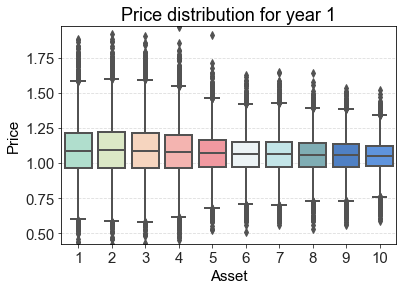

In [20]:
ax = sns.boxplot(x='Asset', y="Year 1", data=df_asset_data)
ax.set_ylabel("Price")
ax.set_title("Price distribution for year 1");

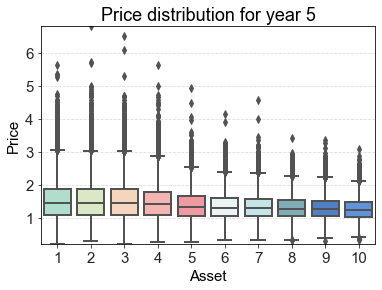

In [21]:
ax = sns.boxplot(x='Asset', y="Year 5", data=df_asset_data)
ax.set_title("Price distribution for year 5")
ax.set_ylabel("Price");

### Kernel density plots / histograms

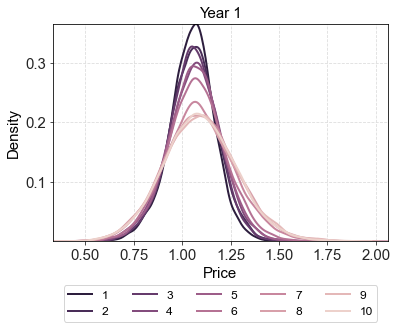

In [22]:
ax = sns.kdeplot(x='Year 1', hue="Asset", data=df_asset_data)
ax.set_xlabel("Price", size=15)
ax.set_title("Year 1", size=15)
ax.legend([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], loc='upper center', bbox_to_anchor=(0.5, -0.175), ncol=5, fontsize=12);

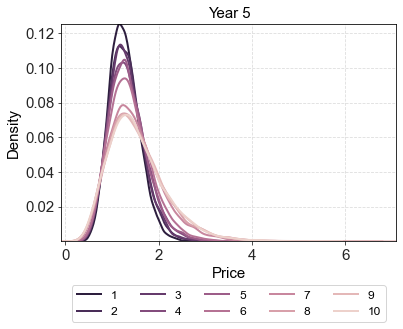

In [23]:
ax = sns.kdeplot(x='Year 5', hue="Asset", data=df_asset_data)
ax.set_xlabel("Price", size=15)
ax.set_title("Year 5", size=15)
ax.legend([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], loc='upper center', bbox_to_anchor=(0.5, -0.175), ncol=5, fontsize=12);

## Constant mix and buy-and-hold

First, we need to calculate the development in the value of each strategy. This follows directly from the exercises in `week 9`. 

The buy-and-hold strategy simply has the value

$$
V_t^{bh} = \mathbf{w}^\top \mathbf{P}_t
$$

For the rebalanced strategy, we need to calculate

$$
V_t^{reb} = 1 (1 + \mathbf{w}^\top \mathbf{R}_1) \cdot ... \cdot (1 + \mathbf{w}^\top \mathbf{R}_t)
$$

In [24]:
"""
Buy and hold strategy 
"""

port_w = np.ones(num_assets) / num_assets

buy_and_hold_index = prices @ port_w

In [25]:
"""
Constant mix porfolio (yearly rebalancing)
"""

def calculate_period_returns(index: np.ndarray):
    
    # get size of matrix
    n = index.shape[1]

    # get matrix not lagged
    new_mat = index[:, 1:n]
    # get matrix lagged
    old_mat = index[:, 0:n-1]
    # get 1 + return
    periodtr = new_mat / old_mat
    
    return periodtr - 1
    

def calculate_constant_mix_index(index, weights):
    
    port_index = np.ones((index.shape[0], index.shape[1]))
    
    # calculate period returns on assets
    per_ret = calculate_period_returns(index)
    
    # calculate port. period return
    port_per_ret = per_ret @ weights
    
    # calculate port. index
    port_index[:, 1:] = np.cumprod(1 + port_per_ret, axis=1)
    
    return port_index

In [26]:
time_points = np.arange(6)
constant_mix_index = calculate_constant_mix_index(prices, port_w)

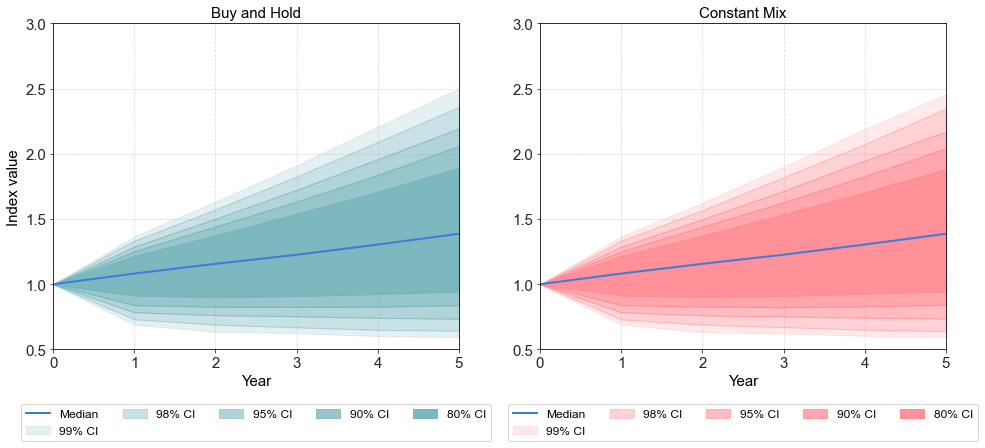

In [27]:
# calculate percentiles
percentiles_buy_and_hold = np.percentile(buy_and_hold_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)

percentiles_constant_mix = np.percentile(constant_mix_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fan_chart(time_points,
          percentiles_buy_and_hold,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[0])

ax[0].set_xlabel("Year", size=15)
ax[0].set_ylabel("Index value", size=15)
ax[0].set_title("Buy and Hold", size=15)
ax[0].set_ylim([0.5, 3.0])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

fan_chart(time_points,
          percentiles_constant_mix,
          color=default_colors['red'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[1])

ax[1].set_xlabel("Year", size=15)
ax[1].set_title("Constant Mix", size=15)
ax[1].set_ylim([0.5, 3.0])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

### Descriptive statistics for portfolios

Since the development in the price of each portfolio have exactly the same structure as the assets, we can simply calculate the descriptive statistics directly on the obtained `numpy.array`s or create a dataframe as above. 

In [28]:
buy_and_hold_index.shape

(10000, 6)

In [29]:
df_bh = pd.DataFrame(data=buy_and_hold_index, columns=['Year 0', 'Year 1', 'Year 2', 'Year 3', 'Year 4', 'Year 5'])
df_bh['Port'] = "Buy and Hold"

df_cm = pd.DataFrame(data=constant_mix_index, columns=['Year 0', 'Year 1', 'Year 2', 'Year 3', 'Year 4', 'Year 5'])
df_cm['Port'] = "Constant Mix"

df_port = pd.concat([df_bh, df_cm])
df_port

,Year 0,Year 1,Year 2,Year 3,Year 4,Year 5,Port
0,1.0,1.065467,1.161152,1.294996,1.402075,1.653415,Buy and Hold
1,1.0,1.007822,1.169703,1.316663,1.365939,1.445069,Buy and Hold
2,1.0,0.894565,0.972284,1.360870,1.627633,1.790011,Buy and Hold
3,1.0,0.963545,0.974041,1.087980,1.262946,1.290492,Buy and Hold
4,1.0,1.042855,0.886166,1.011292,1.211752,1.436445,Buy and Hold
...,...,...,...,...,...,...,...
9995,1.0,1.049134,0.984718,1.044540,0.870922,0.996165,Constant Mix
9996,1.0,1.186236,1.170358,1.278515,1.193255,1.502007,Constant Mix
9997,1.0,0.903063,0.935747,1.083464,1.235654,1.412051,Constant Mix
9998,1.0,1.127526,1.109484,1.382074,1.439420,1.626821,Constant Mix


In [30]:
"""
Function that also works when we need to add views
"""

def cond_value_at_risk(x, alpha=0.05, probs=None, axis=0):
    
    x = np.asarray(x)
    ndim = x.ndim

    # make sure the probs are set
    if probs is None:
        if ndim == 1:
            probs = np.ones_like(x) / len(x)
        elif axis == 0:
            length = x.shape[0]
            probs = np.ones(length) / length
        elif axis == 1:
            length = x.shape[1]
            probs = np.ones(length) / length
        else:
            raise ValueError('probs cannot be set')
    
    if ndim == 1: 
        
        perc = weighted_percentile(x, p=alpha, probs=probs)
        idx = np.less(x, perc)
        
        if np.sum(idx) == 0: # Just return the mean if all values are the same. 
            
            return np.mean(x)
        
        else:
            return np.average(x[idx], weights=probs[idx])
        
    else:
        return np.apply_along_axis(cond_value_at_risk, axis, x, p, probs)

In [31]:
var_5pct = lambda x: weighted_percentile(x, 0.05)

port_stat = df_port.groupby('Port').agg(['mean',
                                         'std',
                                         'skew',
                                         stats.kurtosis,
                                         var_5pct,
                                         cond_value_at_risk]).loc[:, ['Year 1', 'Year 5']]

port_stat.rename(columns={'<lambda_0>': 'VaR(5%)'}, inplace=True)
port_stat.rename(columns={'cond_value_at_risk': 'CVaR(5%)'}, inplace=True)

port_stat

Year 1                                                   \
                  mean       std      skew  kurtosis  VaR(5%)  CVaR(5%)   
Port                                                                      
Buy and Hold  1.072314  0.122671 -0.530503  0.807976  0.84023  0.770999   
Constant Mix  1.072314  0.122671 -0.530503  0.807976  0.84023  0.770999   

                Year 5                                                    
                  mean       std      skew  kurtosis   VaR(5%)  CVaR(5%)  
Port                                                                      
Buy and Hold  1.407453  0.372615  0.418410  0.466916  0.840035  0.720018  
Constant Mix  1.404248  0.367125  0.382258  0.408557  0.842351  0.720740

### Visualizing the VaR and CVaR

Inspiration to this problem can be found in the material for `week 4`. Below, I present one example.

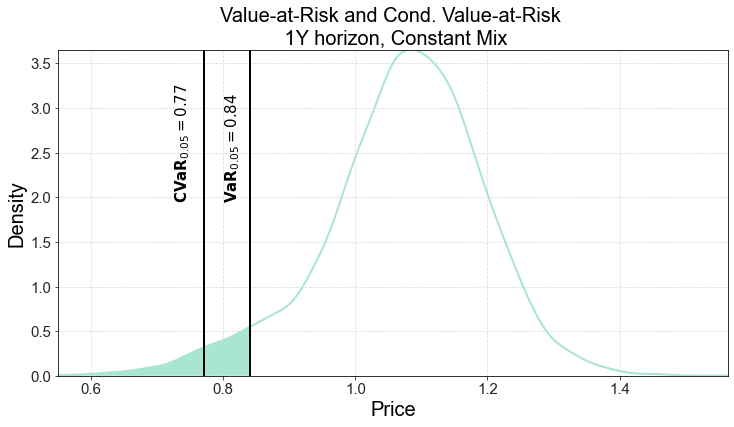

In [32]:
"""
1Y VaR and CVaR for constant mix
"""

dist = constant_mix_index[:, 1]
kde = stats.gaussian_kde(dist)

fig, ax = plt.subplots(figsize=(12, 6))

# plot complete kde curve as line
pos = np.linspace(dist.min(), dist.max(), 1001)
ax.plot(pos, kde(pos))

# plot shaded kde
ax.fill_between(pos, kde(pos), where=pos<port_stat.loc['Constant Mix', 'Year 1']['VaR(5%)'])
ax.axvline(port_stat.loc['Constant Mix', 'Year 1']['VaR(5%)'], color="black")
ax.axvline(port_stat.loc['Constant Mix', 'Year 1']['CVaR(5%)'], color="black")

ax.set_title("Value-at-Risk and Cond. Value-at-Risk \n 1Y horizon, Constant Mix", size=20)
ax.set_xlabel('Price', size=20)
ax.set_ylabel('Density', size=20);

# add text
text_to_add =  "$\mathbf{VaR}_{0.05}" + " = {:,.2f}$".format(port_stat.loc['Constant Mix', 'Year 1']['VaR(5%)'])
ax.text(0.8, 2.0, text_to_add, rotation=90);

text_to_add_2 =  "$\mathbf{CVaR}_{0.05}" + " = {:,.2f}$".format(port_stat.loc['Constant Mix', 'Year 1']['CVaR(5%)'])
ax.text(0.725, 2.0, text_to_add_2, rotation=90);


ax.set_ylim(0,None);

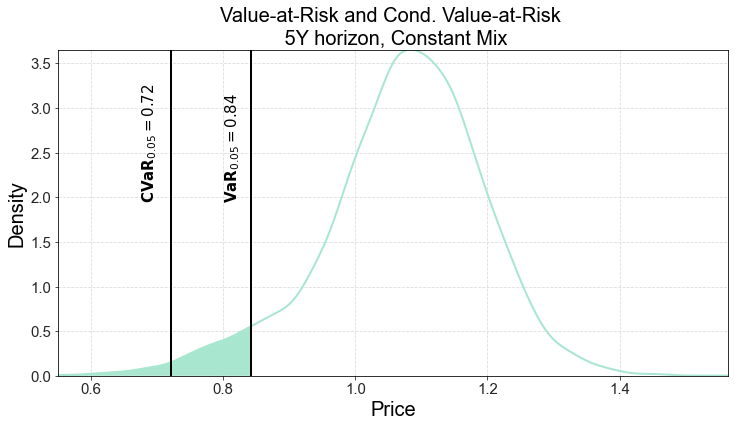

In [33]:
"""
5Y VaR and CVaR for constant mix
"""

dist = constant_mix_index[:, 1]
kde = stats.gaussian_kde(dist)

fig, ax = plt.subplots(figsize=(12, 6))

# plot complete kde curve as line
pos = np.linspace(dist.min(), dist.max(), 1001)
ax.plot(pos, kde(pos))

# plot shaded kde
ax.fill_between(pos, kde(pos), where=pos<port_stat.loc['Constant Mix', 'Year 5']['VaR(5%)'])
ax.axvline(port_stat.loc['Constant Mix', 'Year 5']['VaR(5%)'], color="black")
ax.axvline(port_stat.loc['Constant Mix', 'Year 5']['CVaR(5%)'], color="black")

ax.set_title("Value-at-Risk and Cond. Value-at-Risk \n 5Y horizon, Constant Mix", size=20)
ax.set_xlabel('Price', size=20)
ax.set_ylabel('Density', size=20);

# add text
text_to_add =  "$\mathbf{VaR}_{0.05}" + " = {:,.2f}$".format(port_stat.loc['Constant Mix', 'Year 5']['VaR(5%)'])
ax.text(0.8, 2.0, text_to_add, rotation=90);

text_to_add_2 =  "$\mathbf{CVaR}_{0.05}" + " = {:,.2f}$".format(port_stat.loc['Constant Mix', 'Year 5']['CVaR(5%)'])
ax.text(0.675, 2.0, text_to_add_2, rotation=90);


ax.set_ylim(0,None);

## Portfolio optimization

Most of the information relevant for the portfolio optimization exercise can be found in the material for week 9 - 11. 

We want perform portfolio optimization using standard deviation and conditional value at risk as risk measures for both the constant mix and buy-and-hold case. We need to include relevant constraints. 

### Buy-and-Hold

The buy-and-hold case is the simplest (note that the rebalanced and buy-and-hold will be identical for year 1). 

As mentioned, we can simply calculate the portfolio value as 

$$
V_t^{bh} = \mathbf{w}^\top \mathbf{P}_t
$$

Thus, we can simply calculate the expected portfolio value as 

$$
\mu_p = \mathbf{w}^\top \boldsymbol{\mu}
$$

and we can simply calculate the portfolio variance as 

$$
\sigma_p^2 = \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

where $\boldsymbol{\Sigma}$ is the covariance matrix of prices or returns depending on what one is using. 

In [34]:
"""
Define two numpy arrays with price information
"""

prices_1y = prices[:, 1]
prices_5y = prices[:, 5]

"""
Calculate covariance matrix
"""

cov_mat_1y = np.cov(prices_1y, rowvar=False)
cov_mat_5y = np.cov(prices_5y, rowvar=False)

In [35]:
"""
Check is 1Y covariance matrix is positive definite
"""

np.all(np.linalg.eigvals(cov_mat_1y) >= 0)

True

In [36]:
"""
Check is 5Y covariance matrix is positive definite
"""

np.all(np.linalg.eigvals(cov_mat_5y) >= 0)

True

#### Mean-Variance

I will minimize variance for a given return target (the specific variance formula follows from the buy-and-hold assumption): 

$$
\underset{\mathbf{w}}{\text{arg min }} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

subject to the budget constraint, a return target and no short selling

$$
\begin{align}
\mathbf{w}^\top \mathbf{1} &= 1 \\
\mathbf{w}^\top \boldsymbol{\mu} &= \bar{\mu}_p \\
w_i &> 0 \; i=1,...,10
\end{align}
$$

In [37]:
"""
Define relevant constraints
"""
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x}

# alternatively use 
bounds = [(0.0, 1.0)] * 10

target_returns = np.arange(1.05, 1.09, 0.005) # this will depend on the returns of the simulated data. 
# target_returns = np.arange(1.3, 1.526, 0.025)

"""
Find optimal weights
"""

optimal_weights = list()
for target_return in target_returns:
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: np.average(prices_1y @ x) - target_return}


    x0 = np.ones(10) / 10.0
    res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat_1y,),
                                 method='SLSQP',
                                 constraints=[sum_to_one_cons, no_short_cons, target_cons], 
                                 options={'ftol': 1e-9, 'disp': True}, bounds=bounds)
    
    optimal_weights.append(res.x)
    
optimal_weights = np.array(optimal_weights)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.013354385376029636
            Iterations: 3
            Function evaluations: 33
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.010751867480178935
            Iterations: 14
            Function evaluations: 154
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.011544644103077489
            Iterations: 25
            Function evaluations: 275
            Gradient evaluations: 25
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0127258083018212
            Iterations: 19
            Function evaluations: 209
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.014190732052988113
            Iterations: 14
            Fun

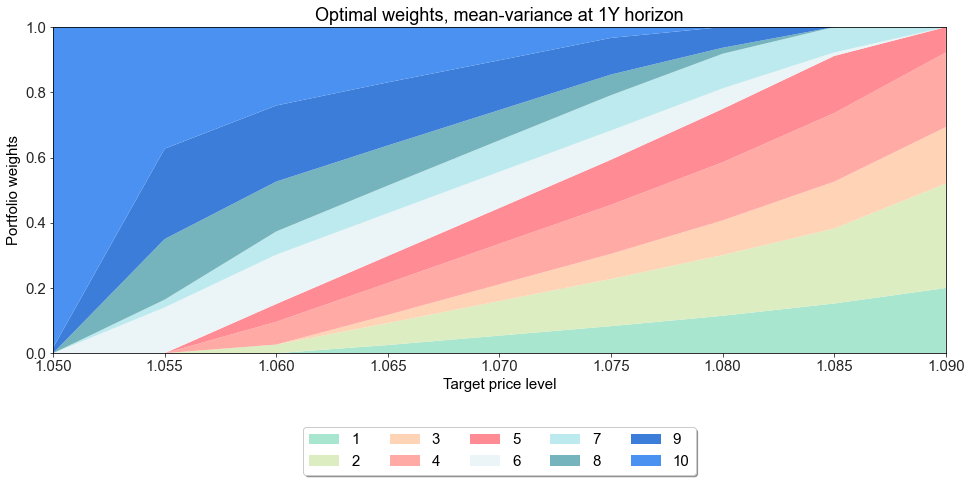

In [38]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.stackplot(target_returns, optimal_weights.T, labels=np.arange(1,11));
ax.set_xlabel("Target price level")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights, mean-variance at 1Y horizon")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5);

In [39]:
"""
Define relevant constraints
"""
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x}

# alternatively use 
bounds = [(0.0, 1.0)] * 10

target_returns = np.arange(1.268294, 1.544342, 0.005) # this will depend on the returns of the simulated data. 
# target_returns = np.arange(1.3, 1.526, 0.025)

"""
Find optimal weights
"""

optimal_weights = list()
for target_return in target_returns:
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: np.average(prices_5y @ x) - target_return}


    x0 = np.ones(10) / 10.0
    res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat_5y,),
                                 method='SLSQP',
                                 constraints=[sum_to_one_cons, no_short_cons, target_cons], 
                                 options={'ftol': 1e-9, 'disp': True}, bounds=bounds)
    
    optimal_weights.append(res.x)
    
optimal_weights = np.array(optimal_weights)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10359141339389717
            Iterations: 3
            Function evaluations: 33
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.09385857922861908
            Iterations: 4
            Function evaluations: 44
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08839524541673044
            Iterations: 5
            Function evaluations: 55
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08555707532768152
            Iterations: 5
            Function evaluations: 55
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08453275179271874
            Iterations: 10
            Function evalua

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.18455762468790834
            Iterations: 15
            Function evaluations: 165
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1891392970603144
            Iterations: 15
            Function evaluations: 166
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.19383976883258433
            Iterations: 14
            Function evaluations: 155
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.19871381085979564
            Iterations: 11
            Function evaluations: 122
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.20381989226497008
            Iterations: 12
            Func

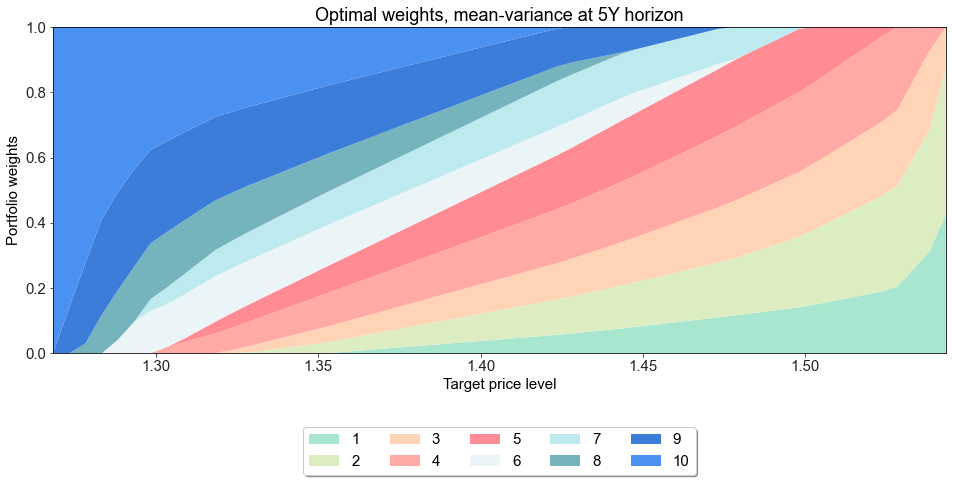

In [40]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.stackplot(target_returns, optimal_weights.T, labels=np.arange(1,11));
ax.set_xlabel("Target price level")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights, mean-variance at 5Y horizon")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5);

#### Conditional Value at Risk

I will be using the approach of [Rockafeller and Uryasev (2000)](https://www.ise.ufl.edu/uryasev/files/2011/11/CVaR1_JOR.pdf)  to solve the problem (see also week 5, exercises)

Basically, the idea is that solving the minimization problem (when using the empirical distribution function)

$$
\underset{\mathbf{w}, \alpha}{\text{arg min }}  \alpha + \frac{1}{N (1 - \beta)} \sum_{i=1}^N \max [0, -\mathbf{w}^\top \mathbf{R}_i- \alpha]
$$

will result in the portfolio with lowest $\text{CVaR}_\beta[R_p]$ given the used constraints. $\alpha$ can be interpreted as the corresponding portfolio $\text{VaR}_\beta[R_p]$. 

We keep the other relevant constraints. 

In [41]:
"""
Define objective function 
"""

def objective_function(x, prices, beta, probs=None):

    w = x[0:-1]
    alpha = x[-1]

    port_returns = prices @ w
    
    T = len(port_returns)

    # tail_scenarios
    tail_scenarios = np.maximum(-port_returns - alpha, 0.0)
    
    if probs is None: 
        obj_func = alpha + np.sum(tail_scenarios) / ( T * (1-beta))
    else: 
        obj_func = alpha + (probs @ tail_scenarios) / (1-beta)

    return obj_func

"""
Define relevant constraitns
"""
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x[:-1]) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x[:-1]}

# alternatively use 
bounds = [(0.0, 1.0)] * 10 + [(None, None)]

target_returns = np.arange(1.05, 1.09, 0.005) # this will depend on the returns of the simulated data. 
# target_returns = np.arange(1.3, 1.526, 0.025)

"""
Find optimal weights
"""

optimal_weights = list()
for target_return in target_returns:
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: np.average(prices_1y @ x[:-1]) - target_return}


    x0 = np.r_[np.ones(10) / 10.0, 0.3]
    res = optimize.minimize(objective_function, x0=x0, args=(prices_1y, 0.95),
                                 method='SLSQP',
                                 constraints=[sum_to_one_cons, no_short_cons, target_cons], 
                                 options={'ftol': 1e-9, 'disp': True}, bounds=bounds)
    
    optimal_weights.append(res.x[:-1])
    
optimal_weights = np.array(optimal_weights)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7885946450075633
            Iterations: 7
            Function evaluations: 88
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7965592704209254
            Iterations: 27
            Function evaluations: 345
            Gradient evaluations: 27
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7906578880502741
            Iterations: 43
            Function evaluations: 540
            Gradient evaluations: 43
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7838911371229355
            Iterations: 51
            Function evaluations: 636
            Gradient evaluations: 51
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7766666819884074
            Iterations: 43
            Functi

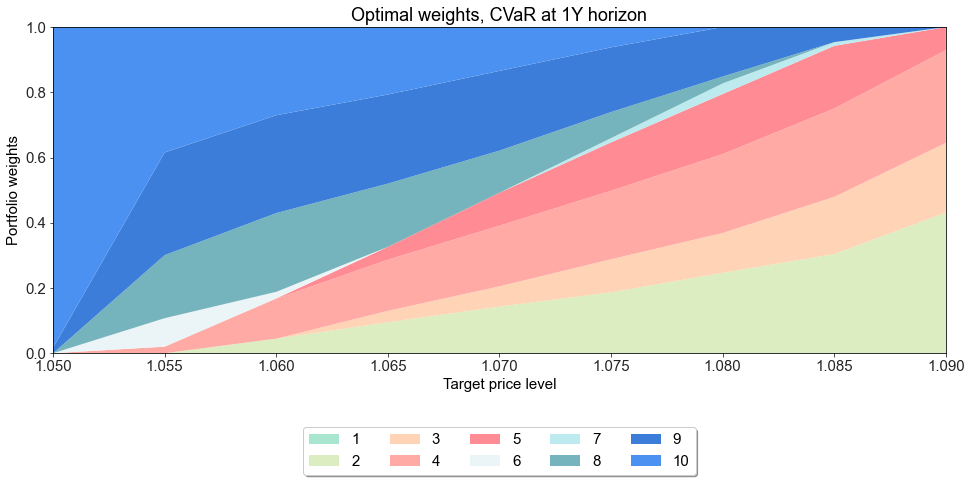

In [42]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(target_returns, optimal_weights.T, labels=np.arange(1,11));
ax.set_xlabel("Target price level")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights, CVaR at 1Y horizon")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5);

In [43]:
target_returns = np.arange(1.268294, 1.544342, 0.005) # this will depend on the returns of the simulated data. 
# target_returns = np.arange(1.3, 1.526, 0.025)

"""
Find optimal weights
"""

optimal_weights = list()
for target_return in target_returns:
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: np.average(prices_5y @ x[:-1]) - target_return}


    x0 = np.r_[np.ones(10) / 10.0, 0.3]
    res = optimize.minimize(objective_function, x0=x0, args=(prices_5y, 0.95),
                                 method='SLSQP',
                                 constraints=[sum_to_one_cons, no_short_cons, target_cons], 
                                 options={'ftol': 1e-9, 'disp': True}, bounds=bounds)
    
    optimal_weights.append(res.x[:-1])
    
optimal_weights = np.array(optimal_weights)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.695435443635034
            Iterations: 7
            Function evaluations: 86
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7145314707227236
            Iterations: 7
            Function evaluations: 86
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7253802100086518
            Iterations: 16
            Function evaluations: 203
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7312333221056021
            Iterations: 18
            Function evaluations: 227
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7344519174792059
            Iterations: 24
            Function e

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7064949038789397
            Iterations: 21
            Function evaluations: 261
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.704633301350282
            Iterations: 31
            Function evaluations: 396
            Gradient evaluations: 31
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7026997399681831
            Iterations: 41
            Function evaluations: 524
            Gradient evaluations: 41
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7007377895820771
            Iterations: 28
            Function evaluations: 362
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6986745978234086
            Iterations: 25
            Func

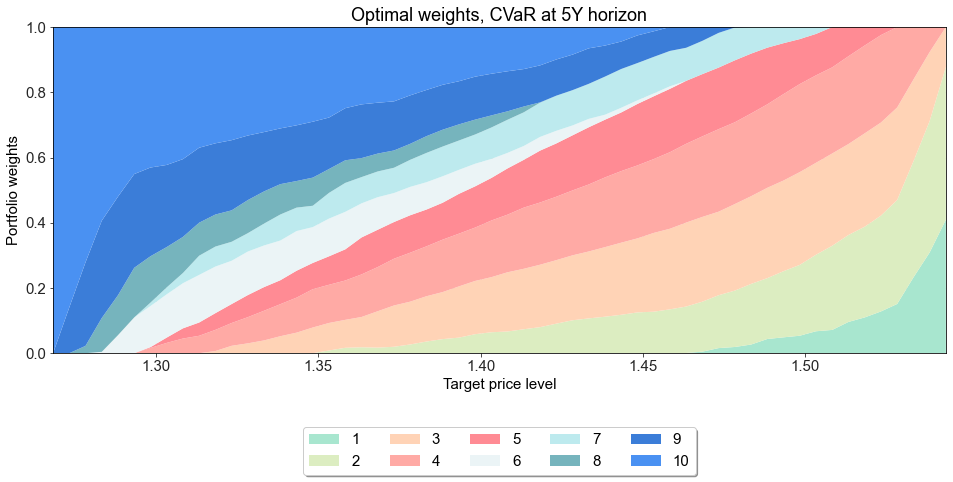

In [44]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(target_returns, optimal_weights.T, labels=np.arange(1,11));
ax.set_xlabel("Target price level")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights, CVaR at 5Y horizon")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5);

### Constant-Mix

#### Mean-Variance 

I will minimize variance for a given return target: 

$$
\underset{\mathbf{w}}{\text{arg min }} \sigma_p^2
$$

subject to the budget constraint, a return target and no short selling

$$
\begin{align}
\mathbf{w}^\top \mathbf{1} &= 1 \\
\mu_p &= \bar{\mu}_p \\
w_i &> 0 \; i=1,...,10
\end{align}
$$

Note that $\sigma_p^2$ and $\mu_p$ now need to be calculated when taking rebalancing into account.

In [45]:
def constant_mix_variance(w, prices, probs=None):

    port_returns = calculate_constant_mix_index(prices, w)
    
    T = len(port_returns)
    
    obj_func = calculate_variance(port_returns[:, -1], probs=probs)

    return obj_func


"""
Define relevant constraints
"""
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x}

# alternatively use 
bounds = [(0.0, 1.0)] * 10

target_returns = np.arange(1.268294, 1.544342, 0.005) # this will depend on the returns of the simulated data. 
# target_returns = np.arange(1.3, 1.526, 0.025)

"""
Find optimal weights
"""

optimal_weights = list()
for target_return in target_returns:
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: np.average(calculate_constant_mix_index(prices, x)[:, -1]) - target_return}


    x0 = np.ones(10) / 10.0
    res = optimize.minimize(constant_mix_variance, x0=x0, args=(prices,),
                                 method='SLSQP',
                                 constraints=[sum_to_one_cons, no_short_cons, target_cons], 
                                 options={'ftol': 1e-9, 'disp': True}, bounds=bounds)
    
    optimal_weights.append(res.x)
    
optimal_weights = np.array(optimal_weights)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10358103491250074
            Iterations: 5
            Function evaluations: 55
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.09374163574974526
            Iterations: 6
            Function evaluations: 66
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08830283587847333
            Iterations: 7
            Function evaluations: 77
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08553219095579771
            Iterations: 7
            Function evaluations: 77
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08454039789516707
            Iterations: 12
            Function evalua

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.17820478503145215
            Iterations: 12
            Function evaluations: 133
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1827076438758014
            Iterations: 13
            Function evaluations: 143
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.18734167211575603
            Iterations: 13
            Function evaluations: 143
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.192108035663142
            Iterations: 14
            Function evaluations: 154
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.19701426545140152
            Iterations: 11
            Functi

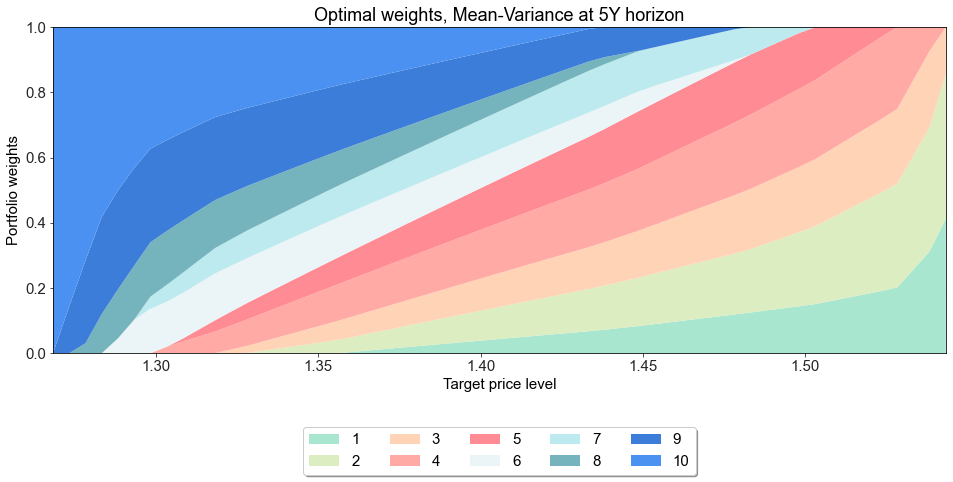

In [46]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(target_returns, optimal_weights.T, labels=np.arange(1,11));
ax.set_xlabel("Target price level")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights, Mean-Variance at 5Y horizon")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5);

#### Conditional Value at Risk 

The optimization problem now reads

$$
\underset{\mathbf{w}, \alpha}{\text{arg min }}  \alpha + \frac{1}{N (1 - \beta)} \sum_{i=1}^N \max [0, -R_{cm}- \alpha]
$$

where $R_{cm}$ is the constant mix portfolio return (taking rebalancing into account). 

We keep other relevant constraints. 

In [47]:
"""
Define objective function 
"""

def objective_function(x, prices, beta, probs=None):

    w = x[0:-1]
    alpha = x[-1]

    port_returns = calculate_constant_mix_index(prices, w)
    
    T = len(port_returns)

    # tail_scenarios
    tail_scenarios = np.maximum(-port_returns[:, -1] - alpha, 0.0)
    
    if probs is None: 
        obj_func = alpha + np.sum(tail_scenarios) / ( T * (1-beta))
    else: 
        obj_func = alpha + (probs @ tail_scenarios) / (1-beta)

    return obj_func


"""
Define relevant constraitns
"""
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x[:-1]) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x[:-1]}

# alternatively use 
bounds = [(0.0, 1.0)] * 10 + [(None, None)]


target_returns = np.arange(1.268294, 1.544342, 0.005) # this will depend on the returns of the simulated data. 
# target_returns = np.arange(1.3, 1.526, 0.025)

"""
Find optimal weights
"""

optimal_weights = list()
for target_return in target_returns:
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: np.average(calculate_constant_mix_index(prices, x[:-1])[:, -1]) - target_return}


    x0 = np.r_[np.ones(10) / 10.0, 0.3]
    res = optimize.minimize(objective_function, x0=x0, args=(prices, 0.95),
                                 method='SLSQP',
                                 constraints=[sum_to_one_cons, no_short_cons, target_cons], 
                                 options={'ftol': 1e-9, 'disp': True}, bounds=bounds)
    
    optimal_weights.append(res.x[:-1])
    
optimal_weights = np.array(optimal_weights)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6954353423692924
            Iterations: 7
            Function evaluations: 86
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7142645553853522
            Iterations: 7
            Function evaluations: 86
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7254847056877233
            Iterations: 17
            Function evaluations: 214
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7313696455721466
            Iterations: 24
            Function evaluations: 302
            Gradient evaluations: 24
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7346737810580422
            Iterations: 28
            Function 

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7063511315659707
            Iterations: 28
            Function evaluations: 351
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7045162559680829
            Iterations: 32
            Function evaluations: 407
            Gradient evaluations: 32
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7026341148402807
            Iterations: 14
            Function evaluations: 181
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7006270119823442
            Iterations: 30
            Function evaluations: 384
            Gradient evaluations: 30
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6984325097910321
            Iterations: 25
            Fun

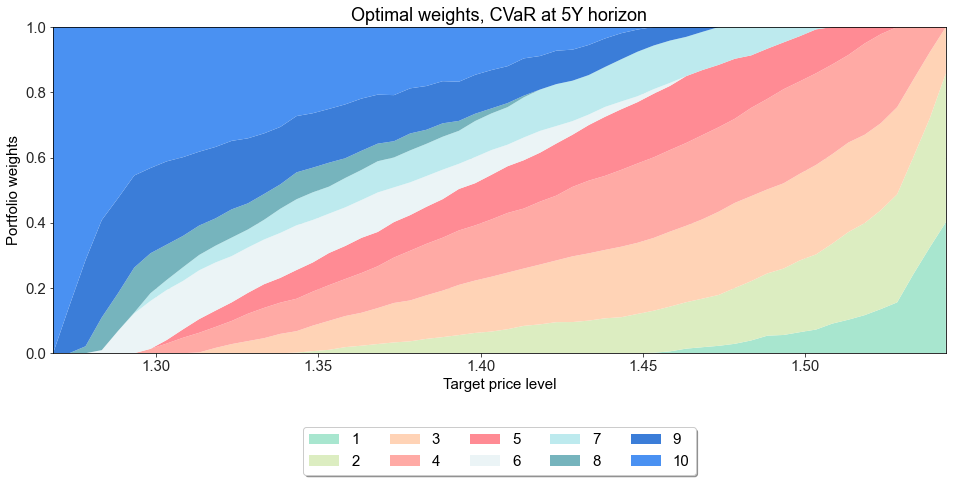

In [48]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.stackplot(target_returns, optimal_weights.T, labels=np.arange(1,11));
ax.set_xlabel("Target price level")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights, CVaR at 5Y horizon")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5);

## Views

If we want to enforce the view that the quantile of a stochastic variable $X$ is less than some value, then it is useful to remember that a quantile can be defined as: 

The quantile function of a random variable, $Q_X$, is the inverse of the cummulative distribution function 

$$
Q_X(p) = F_X^{-1}(p)
$$

such that 

$$
P(X \leq Q_X(p)) = p
$$

So basically, we need to be able to enforce that the probability of observing a value of $X$ equal to or less than $Q_X(p)$ (for convenience we label it $q$) is equal to $p$.


Furthermore, we note that if we have an indicator variable $I(X)$

$$
I(X) = \left \{ \begin{matrix} 1   \text{ if } X \leq q \\ 0  \text{ if } X > q  \end{matrix}\right. 
$$

and that boolean random variables  (as the indicator variable) have the property that 

$$
\text{E}[I(X)] = p \cdot 1 + (1-p) \cdot 0 = p = \text{Prob}[I(X) = 1]
$$

Thus, we can enforce a view on a quantile based on the expected value of an indicator variable. Eg. saying that the 10th percentile is equal to $q$ is the same as saying that the expected value of $X\leq q$ is equal to $p=0.1$. 

### Specific implementation

The above theory should makes it evident that the view can be implemented as a view on the expected value of a new indicator variable. For an equality view, we would specify

$$
(\mathbf{x} \leq q)^\top \tilde{\mathbf{p}} = p
$$

or alternatively 

$$
(\mathbf{x} > q)^\top \tilde{\mathbf{p}} = 1 - p
$$

where $\mathbf{x}$ is a vector of asset prices for a given year. 


I implement a new view that can be used together with the already specified View class. 

In [49]:
class QuantileView(View):
    
    """
    Class that implements a quantile view.
    """

    def __init__(self, view_type: str, factor: np.ndarray, quantile: float, quantile_value: float):
        """
        Constructor

        Parameters
        ----------
        view_type
            Specifies view type.
        factor:
            Factor for which we have a view
        quantile:
            Quantile, e.g. 0.05 for 5% quantile.
        quantile_value:
            Quantile value. 
        """

        super().__init__(view_type)

        self.constraint_matrix = (factor > quantile_value).astype(int)
        self.constraint_vector = 1.0 - quantile

    def get_constraint_matrix(self):
        return self.constraint_matrix

    def get_constraint_vector(self):
        return self.constraint_vector

#### 1Y Horizon

I only implement the views for the 1Y horizon since the approach for the 5Y horizon is similar. 

In [50]:
"""
Implementing views - 1Y horizon
"""
# intitial probs
init_probs = np.ones(len(prices)) / len(prices)

# view that 10% percentile is less than or equal to 0.7 for the first three assets
quantile_views = [QuantileView('leq', prices[:, 1, i], 0.1, 0.7) for i in range(3)]

view_solver = ProbabilitySolver(init_probs, quantile_views)
probs_1y = view_solver.minimize_entropy()

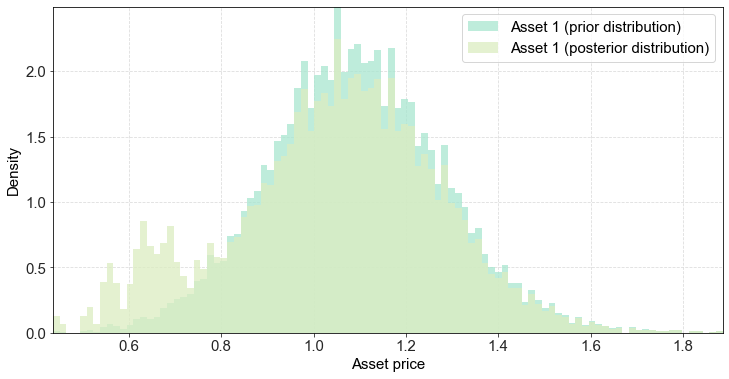

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(prices[:, 1, 0], density=True, bins=100, label="Asset 1 (prior distribution)", alpha=0.75);
ax.hist(prices[:, 1, 0], density=True, bins=100, label="Asset 1 (posterior distribution)", alpha=0.75,
        weights=probs_1y);

ax.set_xlabel("Asset price")
ax.set_ylabel("Density")
#ax.set_title("Asset of equally weighted portfolio")
ax.legend();
#ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1));

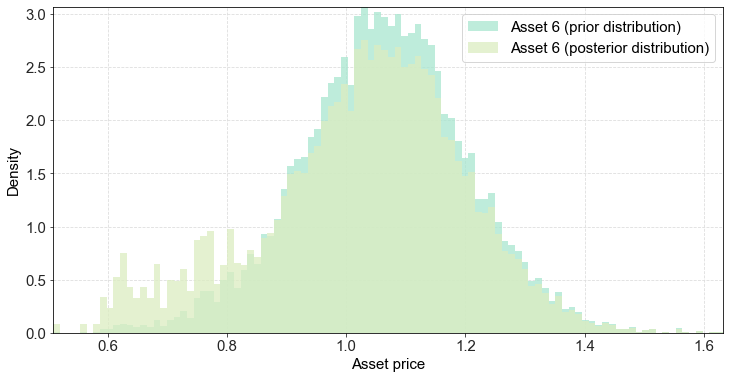

In [52]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(prices[:, 1, 5], density=True, bins=100, label="Asset 6 (prior distribution)", alpha=0.75);
ax.hist(prices[:, 1, 5], density=True, bins=100, label="Asset 6 (posterior distribution)", alpha=0.75,
        weights=probs_1y);

ax.set_xlabel("Asset price")
ax.set_ylabel("Density")
#ax.set_title("Asset of equally weighted portfolio")
ax.legend();
#ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1));

To calculate relevant descriptive statistics for the asset distribution, we need to realize that the moments, etc. will depend on the obtained posterior probabilities. 

In [53]:
"""
Define skewness
"""

def calculate_skewness(x: np.ndarray, probs=None, axis=0):
    
    m_x = np.average(x, weights=probs, axis=axis)
    m_x_3 = np.average(x**3, weights=probs, axis=axis)
    std = calculate_std(x, probs=probs, axis=axis)
    
    return (m_x_3 - 3 * m_x * std**2 - m_x**3) / (std**3)

"""
Define kurtosis
"""

def calculate_kurtosis(x: np.ndarray, probs=None, excess=True, axis=0):
    
    x_d = x - np.average(x, weights=probs, axis=axis)
    m_x_d_4 = np.average(x_d**4, weights=probs, axis=axis)
    
    std = calculate_std(x, probs=probs, axis=axis)
    
    if excess:
        return m_x_d_4 / (std**4) - 3.0
    else: 
        return m_x_d_4 / (std**4)

In [54]:
calc_mean = lambda x: np.average(x, weights=probs_1y, axis=0)
calc_std = lambda x: calculate_std(x, probs=probs_1y, axis=0)
calc_skew = lambda x: calculate_skewness(x, probs=probs_1y, axis=0)
calc_kurt = lambda x: calculate_kurtosis(x, probs=probs_1y, axis=0)

asset_stat_w_views_1y = df_asset_data.groupby("Asset").agg([calc_mean,
                                                            calc_std,
                                                            calc_skew,
                                                            calc_kurt]).loc[:, ['Year 1', 'Year 5']]

asset_stat_w_views_1y.rename(columns={'<lambda_0>': 'Mean'}, inplace=True)
asset_stat_w_views_1y.rename(columns={'<lambda_1>': 'Std'}, inplace=True)
asset_stat_w_views_1y.rename(columns={'<lambda_2>': 'Skew'}, inplace=True)
asset_stat_w_views_1y.rename(columns={'<lambda_3>': 'Kurt'}, inplace=True)

<ipython-input-53-624aeb2ebe75>:11: RuntimeWarning: invalid value encountered in double_scalars
  return (m_x_3 - 3 * m_x * std**2 - m_x**3) / (std**3)
<ipython-input-53-624aeb2ebe75>:25: RuntimeWarning: invalid value encountered in double_scalars
  return m_x_d_4 / (std**4) - 3.0


In [55]:
asset_stat_w_views_1y

Year 1                                  Year 5                      \
           Mean       Std      Skew      Kurt      Mean       Std      Skew   
Asset                                                                         
1      1.046473  0.227376 -0.170755 -0.068924  1.480455  0.636825  1.045079   
2      1.049118  0.229349 -0.137764 -0.082096  1.476928  0.636557  1.094504   
3      1.045772  0.228072 -0.121744 -0.115109  1.471455  0.625676  1.078631   
4      1.045070  0.211771 -0.140285  0.097010  1.432941  0.575229  0.978526   
5      1.036383  0.179585 -0.236714  0.099551  1.347042  0.461476  0.796780   
6      1.027849  0.171039 -0.397144  0.066096  1.304298  0.418756  0.736293   
7      1.029890  0.165597 -0.297716 -0.013543  1.304313  0.414541  0.722408   
8      1.025076  0.154961 -0.436677  0.142928  1.268784  0.371956  0.561628   
9      1.024273  0.155885 -0.434810  0.123218  1.265277  0.368903  0.567625   
10     1.020692  0.142541 -0.492875  0.183600  1.232952  0.332137  0.474603   

                 
           Kurt  
Asset            
1      1.816185  
2      2.291346  
3      2.134017  
4      1.721456  
5      1.305963  
6      1.016755  
7      1.129802  
8      0.447256  
9      0.643076  
10     0.347194

### Consequence for equally weighted portfolios

In [56]:
"""
Previous statistics
"""

var_5pct = lambda x: weighted_percentile(x, 0.05)

port_stat = df_port.groupby('Port').agg(['mean',
                                         'std',
                                         'skew',
                                         stats.kurtosis,
                                         var_5pct,
                                         cond_value_at_risk]).loc[:, ['Year 1', 'Year 5']]

port_stat.rename(columns={'<lambda_0>': 'VaR(5%)'}, inplace=True)
port_stat.rename(columns={'cond_value_at_risk': 'CVaR(5%)'}, inplace=True)

port_stat

Year 1                                                   \
                  mean       std      skew  kurtosis  VaR(5%)  CVaR(5%)   
Port                                                                      
Buy and Hold  1.072314  0.122671 -0.530503  0.807976  0.84023  0.770999   
Constant Mix  1.072314  0.122671 -0.530503  0.807976  0.84023  0.770999   

                Year 5                                                    
                  mean       std      skew  kurtosis   VaR(5%)  CVaR(5%)  
Port                                                                      
Buy and Hold  1.407453  0.372615  0.418410  0.466916  0.840035  0.720018  
Constant Mix  1.404248  0.367125  0.382258  0.408557  0.842351  0.720740

In [57]:
"""
New statistics
"""

var_5pct = lambda x: weighted_percentile(x, 0.05, probs=probs_1y)
cvar_5pct =  lambda x: cond_value_at_risk(x, 0.05, probs=probs_1y)

port_stat_w_views_1y = df_port.groupby('Port').agg([calc_mean,
                                                    calc_std,
                                                    calc_skew,
                                                    calc_kurt,
                                                    var_5pct,
                                                    cvar_5pct]).loc[:, ['Year 1', 'Year 5']]

port_stat_w_views_1y.rename(columns={'<lambda_0>': 'Mean'}, inplace=True)
port_stat_w_views_1y.rename(columns={'<lambda_1>': 'Std'}, inplace=True)
port_stat_w_views_1y.rename(columns={'<lambda_2>': 'Skew'}, inplace=True)
port_stat_w_views_1y.rename(columns={'<lambda_3>': 'Kurt'}, inplace=True)
port_stat_w_views_1y.rename(columns={'<lambda_4>': 'VaR(5%)'}, inplace=True)
port_stat_w_views_1y.rename(columns={'<lambda_5>': 'CVaR(5%)'}, inplace=True)

port_stat_w_views_1y


<ipython-input-53-624aeb2ebe75>:11: RuntimeWarning: invalid value encountered in double_scalars
  return (m_x_3 - 3 * m_x * std**2 - m_x**3) / (std**3)
<ipython-input-53-624aeb2ebe75>:25: RuntimeWarning: invalid value encountered in double_scalars
  return m_x_d_4 / (std**4) - 3.0


Year 1                                                    \
                 Mean       Std      Skew      Kurt   VaR(5%)  CVaR(5%)   
Port                                                                      
Buy and Hold  1.03506  0.161361 -0.788242  0.263405  0.695359  0.647338   
Constant Mix  1.03506  0.161361 -0.788242  0.263405  0.695359  0.647338   

                Year 5                                                    
                  Mean       Std      Skew      Kurt   VaR(5%)  CVaR(5%)  
Port                                                                      
Buy and Hold  1.358444  0.388805  0.393444  0.289297  0.749459  0.654449  
Constant Mix  1.355831  0.383448  0.360373  0.230689  0.750162  0.656717

### Portfolio optimization

In [58]:
"""
Define objective function 
"""

def objective_function(x, prices, beta, probs=None):

    w = x[0:-1]
    alpha = x[-1]

    port_returns = prices @ w
    
    T = len(port_returns)

    # tail_scenarios
    tail_scenarios = np.maximum(-port_returns - alpha, 0.0)
    
    if probs is None: 
        obj_func = alpha + np.sum(tail_scenarios) / ( T * (1-beta))
    else: 
        obj_func = alpha + (probs @ tail_scenarios) / (1-beta)

    return obj_func

# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x[:-1]) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x[:-1]}

# alternatively use 
bounds = [(0.0, 1.0)] * 10 + [(None, None)]

target_returns = np.arange(1.025, 1.049, 0.001)

optimal_weights = list()
for target_return in target_returns:
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: np.average(prices_1y @ x[:-1], weights=probs_1y) - target_return}


    x0 = np.r_[np.ones(10) / 10.0, 0.3]
    res = optimize.minimize(objective_function, x0=x0, args=(prices_1y, 0.95, probs_1y),
                                 method='SLSQP',
                                 constraints=[sum_to_one_cons, no_short_cons, target_cons], 
                                 options={'ftol': 1e-9, 'disp': True}, bounds=bounds)
    
    optimal_weights.append(res.x[:-1])
    
optimal_weights = np.array(optimal_weights)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6859463469757731
            Iterations: 30
            Function evaluations: 392
            Gradient evaluations: 30
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6835005619375863
            Iterations: 57
            Function evaluations: 723
            Gradient evaluations: 57
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6809297545251772
            Iterations: 30
            Function evaluations: 394
            Gradient evaluations: 30
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6782757120096515
            Iterations: 47
            Function evaluations: 606
            Gradient evaluations: 47
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6756145569003174
            Iterations: 36
            Fun

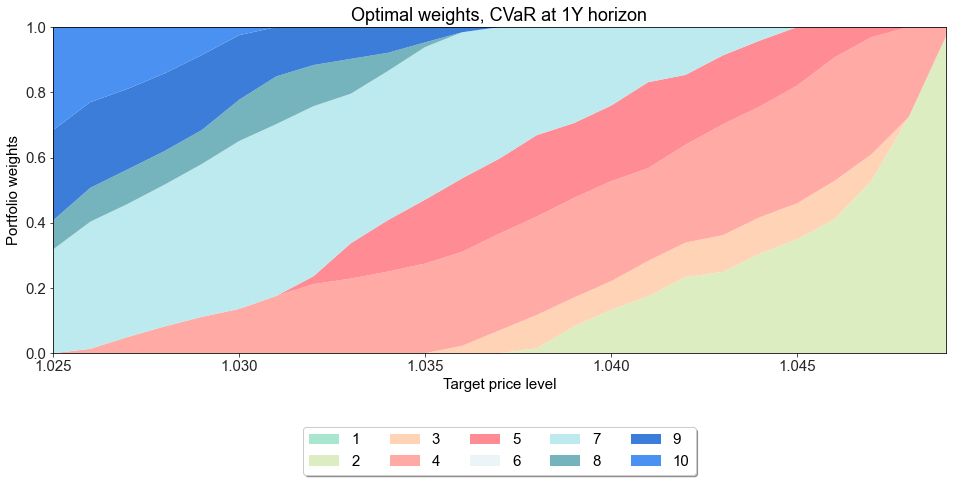

In [59]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(target_returns, optimal_weights.T, labels=np.arange(1,11));
ax.set_xlabel("Target price level")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights, CVaR at 1Y horizon")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5);

# Problem 2: CIR model

In this problem, we work with the Cox-Ingersoll-Ross short rate model. 

## Simulate the short rate into the future

The simplest way to simulate the model is to use the discretiziation 

$$
r_{t+\Delta t} = r_t + \kappa [\theta - r_t] \Delta t + \beta \sqrt{r_t} \varepsilon_{t+1}
$$

where $\varepsilon_{t+1} \sim N(0, \Delta t)$. 

Note: The distribution of future short rates will be the same under P and Q since $\lambda=0$. 

In [60]:
def simulate_cir(initial_short_rate: float, kappa: float, theta: float, beta: float, horizon: float, 
                     dt: float=1.0/12, num_sim: int=10000):
    """
    simulates short rate processes in a CIR setting until a given horizon 
    
    Parameters
    ----------
    
    initial_short_rate:
        initial short rate
    kappa: 
        speed of mean reversion.
    theta: 
        long term mean of the short rate.
    beta:
        Std. parameter. 
    dt:
        increments in time
    horizon:
        time until maturity/expiry (horizon).
    num_sim:
        number of simulations.
    """

    num_periods = int(horizon / dt)
    short_rates = np.empty((num_sim, num_periods + 1))
    short_rates[:, 0] = initial_short_rate
    
    error_terms = np.random.normal(size=(num_sim, num_periods))
    
    for i in range(1, num_periods + 1): 
        short_rates[:, i] = (short_rates[:, i - 1] + kappa * (theta - short_rates[:, i - 1]) * dt +
                             beta * np.sqrt(short_rates[:, i - 1]) * error_terms[:, i - 1] * np.sqrt(dt))

    return short_rates

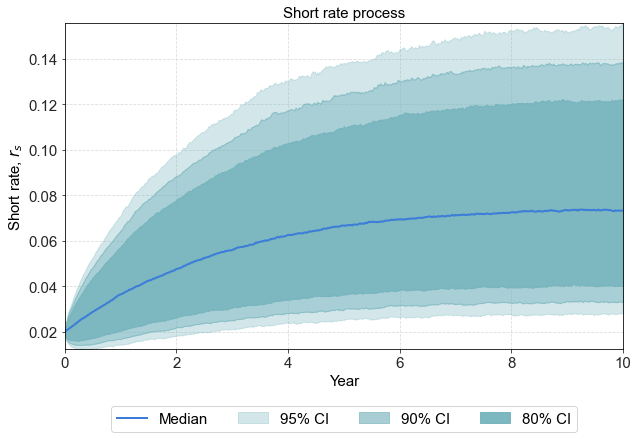

In [61]:
initial_rate = 0.02
kappa=0.36
theta=0.08
beta=0.1
horizon=10
dt=1.0/52.0
num_sim=10000

short_rates = simulate_cir(initial_rate, kappa=kappa, theta=theta, beta=beta,
                               horizon=horizon, dt=dt, num_sim=num_sim)
time_points = np.arange(0, 10.01, dt)

# calculate percentiles
percentiles = np.percentile(short_rates, [2.5, 5, 10, 50, 90, 95, 97.5], axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points,
          percentiles,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_ylabel("Short rate, $r_s$", size=15)
ax.set_title("Short rate process", size=15)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=15);

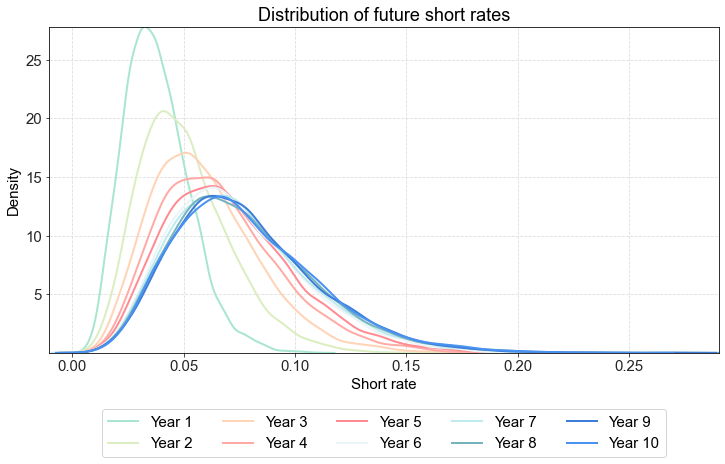

In [62]:
fig, ax = plt.subplots(figsize=(12,6))

for idx in [52 * _ for _ in range(1, 11)]:
    sns.kdeplot(short_rates[:, idx], label="Year {}".format(int(idx / 52)))
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=15);
ax.set_title("Distribution of future short rates");
ax.set_xlabel('Short rate');

In [63]:
def cir_mean(initial_short_rate: float, kappa: float, theta: float, horizon: float):
    
    return theta + (initial_short_rate - theta) * np.exp(-kappa * horizon)

def cir_variance(initial_short_rate: float, kappa: float, theta: float, beta: float, horizon: float):
    
    part1 = beta**2 * initial_short_rate / kappa * (np.exp(-kappa * horizon) - np.exp(-2 * kappa * horizon))
    part2 = beta**2 * theta / (2 * kappa) * (1 - np.exp(-kappa * horizon))**2
    
    return part1 + part2

In [64]:
exact_mean = cir_mean(initial_rate, kappa, theta, time_points)
exact_variance = cir_variance(initial_rate, kappa, theta,  beta, time_points)

sim_mean = np.mean(short_rates, axis=0)
sim_variance = np.var(short_rates, axis=0)

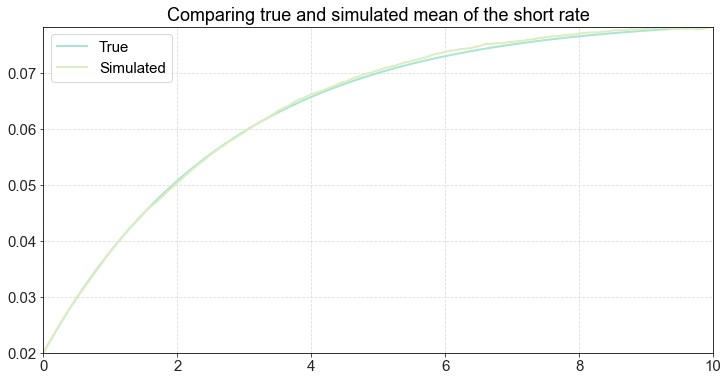

In [65]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time_points, exact_mean, label="True")
ax.plot(time_points, sim_mean, label="Simulated")
ax.set_title("Comparing true and simulated mean of the short rate")
ax.legend();

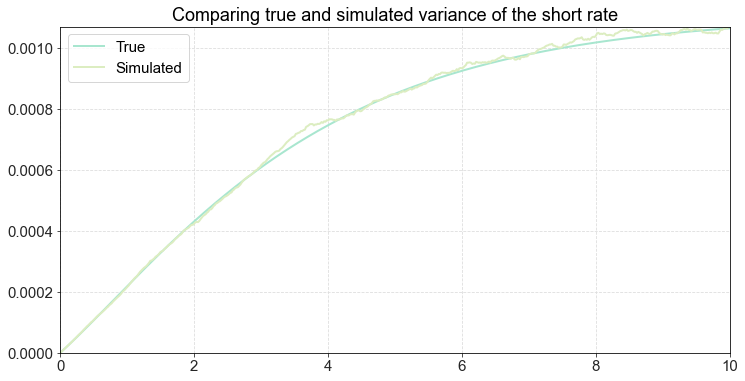

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time_points, exact_variance, label="True")
ax.plot(time_points, sim_variance, label="Simulated")
ax.set_title("Comparing true and simulated variance of the short rate")
ax.legend();

### Check with exact distribution

In [67]:
"""
Check with true distribution 
"""
 

def simulate_cir_exact(initial_short_rate: float, kappa: float, theta: float, beta: float, horizon: float, 
                     dt: float=1.0/12, num_sim: int=10000):
    """
    simulates short rate processes in a CIR setting until a given horizon 
    
    Parameters
    ----------
    
    initial_short_rate:
        initial short rate
    kappa: 
        speed of mean reversion.
    theta: 
        long term mean of the short rate.
    dt:
        increments in time
    horizon:
        time until maturity/expiry (horizon).
    num_sim:
        number of simulations.
    """
    
    # auxilliary constants
    a = 4 * kappa * theta / (beta**2)
    c = 4 * kappa /(beta**2 * (1 - np.exp(-kappa * dt)))
    
    num_periods = int(horizon / dt)
    short_rates = np.empty((num_sim, num_periods + 1))
    short_rates[:, 0] = initial_short_rate
    
    for i in range(1, num_periods + 1): 
        for j in range(num_sim):
            b = short_rates[j, i - 1] * c * np.exp(-kappa * dt)
            short_rates[j, i] = stats.ncx2.rvs(a, b, scale=(1 / c))

    return short_rates

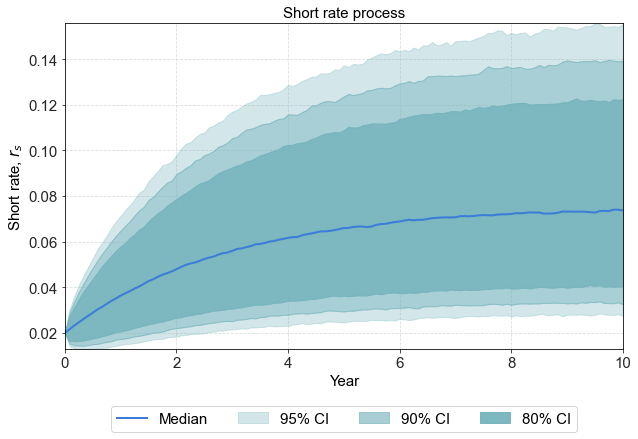

In [68]:
initial_rate = 0.02
kappa=0.36
theta=0.08
beta=0.1
horizon=10
dt=1.0/12.0
num_sim=10000

short_rates_exact = simulate_cir_exact(initial_rate, kappa=kappa, theta=theta, beta=beta,
                               horizon=horizon, dt=dt, num_sim=num_sim)
time_points_exact = np.arange(0, 10.01, dt)

# calculate percentiles
percentiles = np.percentile(short_rates_exact, [2.5, 5, 10, 50, 90, 95, 97.5], axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points_exact,
          percentiles,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_ylabel("Short rate, $r_s$", size=15)
ax.set_title("Short rate process", size=15)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=15);

In [69]:
exact_mean = cir_mean(initial_rate, kappa, theta, time_points_exact)
exact_variance = cir_variance(initial_rate, kappa, theta,  beta, time_points_exact)

sim_mean_2 = np.mean(short_rates_exact, axis=0)
sim_variance_2 = np.var(short_rates_exact, axis=0)

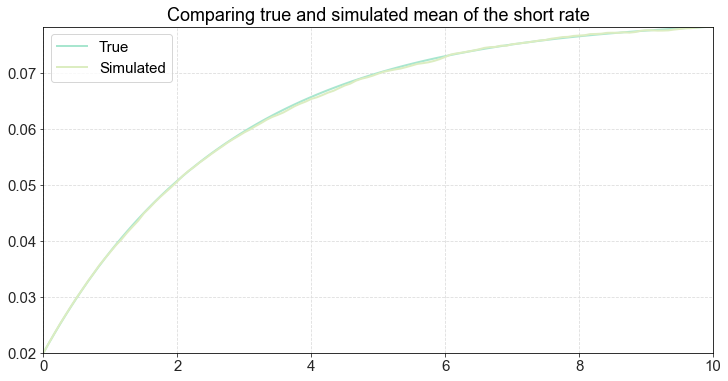

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time_points_exact, exact_mean, label="True")
ax.plot(time_points_exact, sim_mean_2, label="Simulated")
ax.set_title("Comparing true and simulated mean of the short rate")
ax.legend();

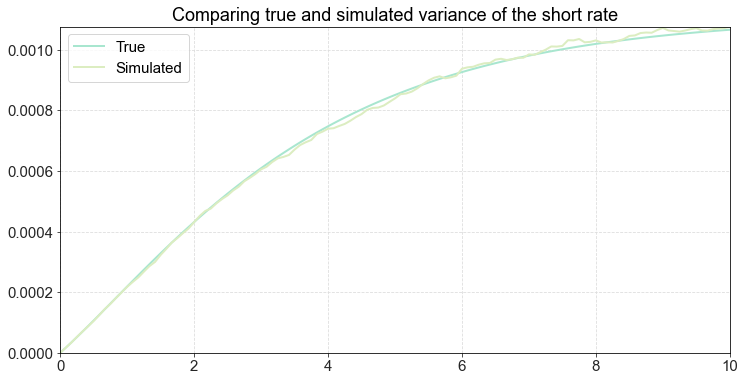

In [71]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time_points_exact, exact_variance, label="True")
ax.plot(time_points_exact, sim_variance_2, label="Simulated")
ax.set_title("Comparing true and simulated variance of the short rate")
ax.legend();

## The yield curve and present value

### Plotting the initial yield curve

One could implement the yield curve as a function. However, I implement the CIR yield curve as a curve object (see `codelib.fixed_income.curves.cir_curve`)

In [72]:
"""
Define the zero curve
"""

zero_curve = CIRCurve(short_rate=initial_rate,
                      beta=beta,
                      kappa=kappa,
                      theta=theta)

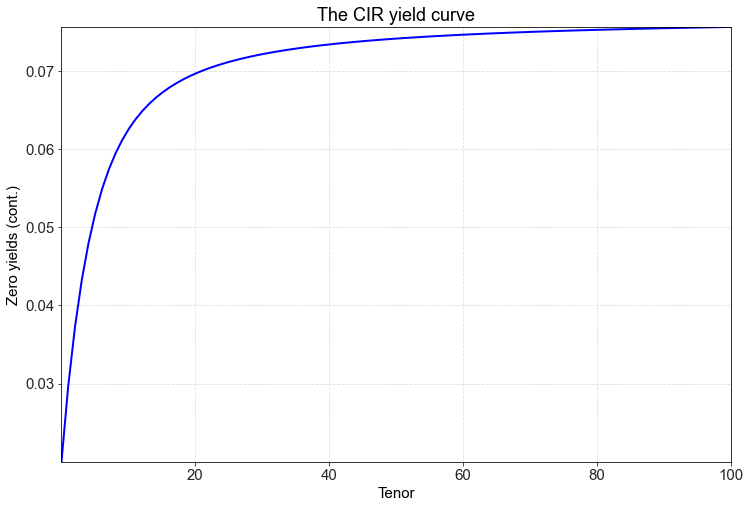

In [73]:
plot_tenors = np.linspace(0.0001, 100.0, 100)

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(plot_tenors, zero_curve.zero_rate_vector(plot_tenors), color="blue")
ax.set_xlabel('Tenor');
ax.set_ylabel('Zero yields (cont.)');
ax.set_title("The CIR yield curve");

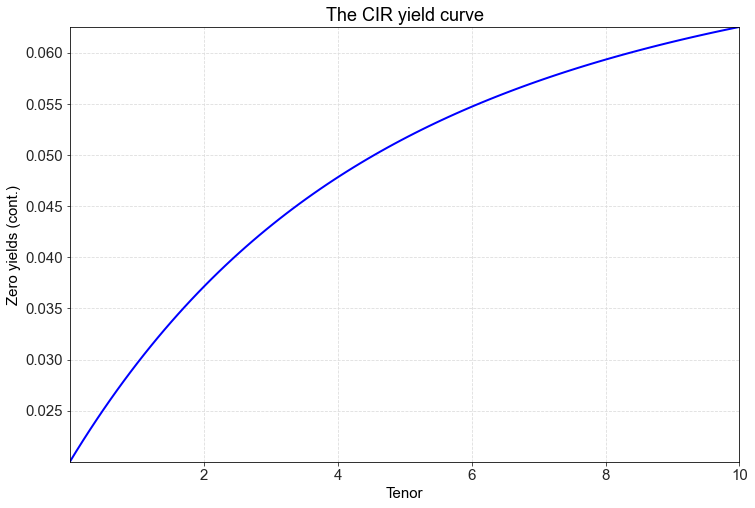

In [74]:
plot_tenors = np.linspace(0.0001, 10.0, 100)

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(plot_tenors, zero_curve.zero_rate_vector(plot_tenors), color="blue")
ax.set_xlabel('Tenor');
ax.set_ylabel('Zero yields (cont.)');
ax.set_title("The CIR yield curve");

In [75]:
"""
Discount factor for the first 10 years
""" 
zero_curve.discount_factor_vector(np.arange(1, 11, 1))

array([0.9708529 , 0.92847093, 0.87881243, 0.8259524 , 0.77253709,
       0.72020545, 0.66991839, 0.62219496, 0.57727362, 0.53521897])

### Present value of the provided cash flow

We can load the cash flow from excel and store it in a `CashFlow` object.

In [76]:
"""
Load the Cash Flow into the dataframe cf
"""

cf = pd.read_excel("cashflow.xlsx", engine='openpyxl', usecols=[0, 1])
cf

,time (T),cf
0,1,1000000
1,2,900000
2,3,800000
3,4,700000
4,5,600000
5,6,500000
6,7,500000
7,8,500000
8,9,500000
9,10,500000


In [77]:
"""
Create a cash flow object
"""

cash_flow = CashFlow(time_points=cf['time (T)'].values, flows=cf['cf'].values)

In [78]:
cash_flow.present_value(curve=zero_curve)

5113621.302359084

### Accumulated cash flow + present value of future cash flow

In [79]:
pv_cash_flow = np.zeros((num_sim, 11))
pv_cash_flow_acc = np.zeros((num_sim, 11))
acc_cf =  np.r_[0, cash_flow.get_cash_flows().cumsum()]
for i in range(num_sim):
    for j in range(11):
        
        k = j * 52
        init_sr = short_rates[i, k]
        
        temp_zero_curve = CIRCurve(init_sr, theta, kappa, beta)
        pv_cash_flow[i, j] = cash_flow.present_value(temp_zero_curve, time_shift=j)
        
        
        pv_cash_flow_acc[i, j] = pv_cash_flow[i, j] + acc_cf[j]
   

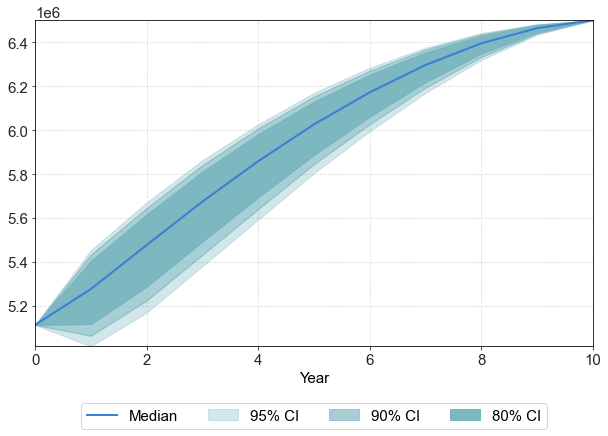

In [80]:
time_points = np.arange(0, 11.0, 1.0)

# calculate percentiles
percentiles = np.percentile(pv_cash_flow_acc, [2.5, 5, 10, 50, 90, 95, 97.5], axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points,
          percentiles,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=15);